<a href="https://colab.research.google.com/github/hubertrykala93/eye-diseases-image-classification/blob/main/eye_diseases_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import os
from shutil import copyfile, rmtree
from math import floor
from typing import Union, List
import numpy as np
import matplotlib.pyplot as plt

from keras_preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.metrics import AUC

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use(style='fivethirtyeight')

# Collecting Data and Remove Unnecessary Files

In [3]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download --force -d gunavenkatdoddi/eye-diseases-classification

Saving kaggle.json to kaggle.json
100% 734M/736M [00:07<00:00, 158MB/s]
100% 736M/736M [00:07<00:00, 109MB/s]


In [4]:
!unzip -q eye-diseases-classification.zip
!rm rf eye-diseases-classification.zip

rm: cannot remove 'rf': No such file or directory


In [5]:
os.rename(src='/content/dataset', dst='/content/files')

# Images Exploration

In [6]:
BASE_DIR = '/content/files'
DATASET_DIR = '/content/dataset'

if not os.path.exists(DATASET_DIR):
  os.mkdir(path=DATASET_DIR)

In [7]:
def show_images(kind: str, id: int = 0, random_choice: bool = False,
                make_subplots: bool = False) -> None:
    """
    Show image from file directories.

    Parameters:
    ----------
    kind: str
      Must be in 'cataract', 'diabetic_retinopathy', 'glaucoma' or normal'.

    id: int
      Index of image, while index will be higher the length of files in directory
      then will raise error.

    random_choice: bool
      If random_choice is True, function choose random image and return it.

    make_subplots: bool
      If make_subplots is True, function choose 12 random images
      and return subplots from this images.

    Returns:
    -------
    matplotlib.pyplot.Axes
    """

    filenames = dict(enumerate(os.listdir(path=os.path.join(BASE_DIR, kind))))

    if id >= len(filenames):
        raise KeyError(f'Wrong index, maximum index is {len(filenames)}.')
    else:
        if not make_subplots:
            if random_choice == False:
                img = load_img(path=os.path.join(BASE_DIR, kind, filenames[id]), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=filenames[id])
                plt.axis('off')
                plt.grid(visible=False)

                plt.show()

            else:
                random_id = filenames[np.random.choice(a=len(filenames))]

                img = load_img(path=os.path.join(BASE_DIR, kind, random_id), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=random_id)
                plt.axis('off')
                plt.grid(visible=False)

                plt.show()

        else:
            indexes = []

            while len(indexes) != 12:
                indexes = list(indexes)
                indexes.append(np.random.choice(a=len(filenames)))

                indexes = set(indexes)

            indexes = list(indexes)

            for i, index in enumerate(indexes):
                plt.subplot(4, 3, i + 1)

                img = load_img(path=os.path.join(BASE_DIR, kind, filenames[index]), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=filenames[index], fontdict={
                    'size': 10
                })
                plt.axis('off')
                plt.grid(visible=False)

            plt.show()

Cataract

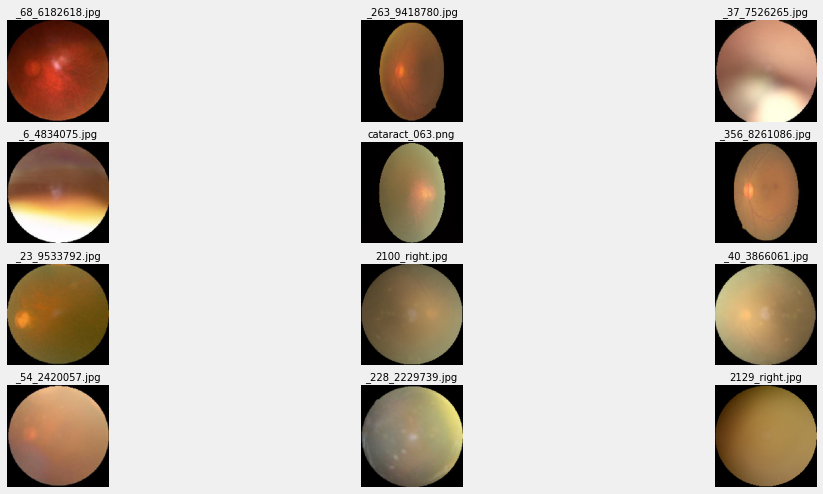

In [8]:
show_images(kind='cataract', id=990, random_choice=False, make_subplots=True)

Diabetic Retinopathy

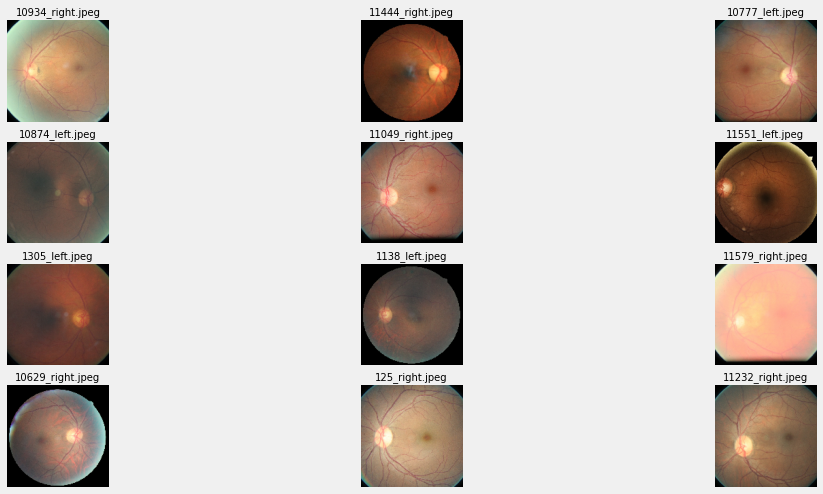

In [9]:
show_images(kind='diabetic_retinopathy', id=990, random_choice=False, make_subplots=True)

Glaucoma

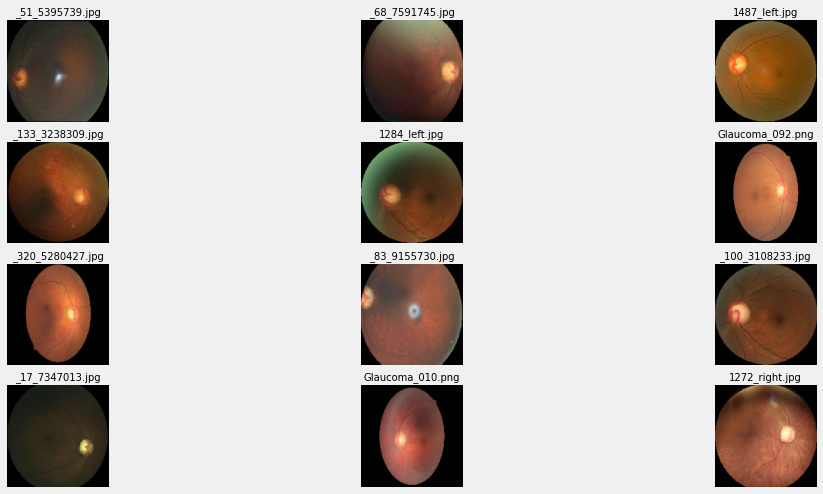

In [10]:
show_images(kind='glaucoma', id=990, random_choice=False, make_subplots=True)

Normal

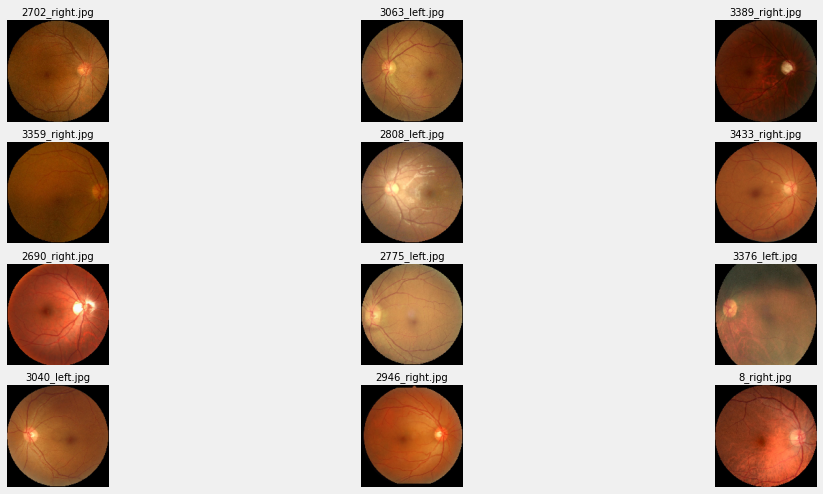

In [11]:
show_images(kind='normal', id=990, random_choice=False, make_subplots=True)

# Creating Dataset with Train and Test Files

In [12]:
cataract_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'cataract'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

diabetic_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'diabetic_retinopathy'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

glaucoma_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'glaucoma'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

normal_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'normal'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

In [13]:
SIZE = min([len(cataract_filenames), len(diabetic_filenames), len(glaucoma_filenames),
        len(normal_filenames)])

TRAIN_SIZE = int(floor(SIZE * 0.7))
VALIDATION_SIZE = int(floor(SIZE * 0.2))
TEST_SIZE = SIZE - TRAIN_SIZE - VALIDATION_SIZE

TRAIN_INDEX = TRAIN_SIZE
VALIDATION_INDEX = TRAIN_SIZE + VALIDATION_SIZE
TEST_INDEX = SIZE

In [14]:
cataract_filenames = cataract_filenames[:SIZE]
diabetic_filenames = diabetic_filenames[:SIZE]
glaucoma_filenames = glaucoma_filenames[:SIZE]
normal_filenames = normal_filenames[:SIZE]

In [15]:
train_dir = os.path.join(DATASET_DIR, 'train')
validation_dir = os.path.join(DATASET_DIR, 'validation')
test_dir = os.path.join(DATASET_DIR, 'test')

train_cataract_dir = os.path.join(train_dir, 'cataract')
train_diabetic_dir = os.path.join(train_dir, 'diabetic_retinopathy')
train_glaucoma_dir = os.path.join(train_dir, 'glaucoma')
train_normal_dir = os.path.join(train_dir, 'normal')

validation_cataract_dir = os.path.join(validation_dir, 'cataract')
validation_diabetic_dir = os.path.join(validation_dir, 'diabetic_retinopathy')
validation_glaucoma_dir = os.path.join(validation_dir, 'glaucoma')
validation_normal_dir = os.path.join(validation_dir, 'normal')

test_cataract_dir = os.path.join(test_dir, 'cataract')
test_diabetic_dir = os.path.join(test_dir, 'diabetic_retinopathy')
test_glaucoma_dir = os.path.join(test_dir, 'glaucoma')
test_normal_dir = os.path.join(test_dir, 'normal')

In [16]:
directories = [train_dir, validation_dir, test_dir, train_cataract_dir, train_diabetic_dir,
               train_glaucoma_dir, train_normal_dir, validation_cataract_dir,
               validation_diabetic_dir, validation_glaucoma_dir, validation_normal_dir,
               test_cataract_dir, test_diabetic_dir, test_glaucoma_dir, test_normal_dir]

for dir in directories:
  if not os.path.exists(path=dir):
    os.mkdir(path=dir)

In [17]:
def create_sets() -> None:
  """
  Copying files from files directory to dataset directory in order to
  creating cataract, diabetic_retinopathy, glaucoma and normal train and test sets.

  Parameters:
  ----------
  directories: list
    List of strings. String must be path to the file.

  Returns:
  -------
  None
  """
  for i, file_1 in enumerate(cataract_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'cataract', file_1)
      dst = os.path.join(train_cataract_dir, file_1)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'cataract', file_1)
      dst = os.path.join(validation_cataract_dir, file_1)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'cataract', file_1)
      dst = os.path.join(test_cataract_dir, file_1)
      copyfile(src=src, dst=dst)

  for i, file_2 in enumerate(diabetic_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'diabetic_retinopathy', file_2)
      dst = os.path.join(train_diabetic_dir, file_2)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'diabetic_retinopathy', file_2)
      dst = os.path.join(validation_diabetic_dir, file_2)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'diabetic_retinopathy', file_2)
      dst = os.path.join(test_diabetic_dir, file_2)
      copyfile(src=src, dst=dst)

  for i, file_3 in enumerate(glaucoma_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'glaucoma', file_3)
      dst = os.path.join(train_glaucoma_dir, file_3)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'glaucoma', file_3)
      dst = os.path.join(validation_glaucoma_dir, file_3)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'glaucoma', file_3)
      dst = os.path.join(test_glaucoma_dir, file_3)
      copyfile(src=src, dst=dst)

  for i, file_4 in enumerate(normal_filenames):
    if i <= TRAIN_INDEX:
      src = os.path.join(BASE_DIR, 'normal', file_4)
      dst = os.path.join(train_normal_dir, file_4)
      copyfile(src=src, dst=dst)
    elif TRAIN_INDEX < i <= VALIDATION_INDEX:
      src = os.path.join(BASE_DIR, 'normal', file_4)
      dst = os.path.join(validation_normal_dir, file_4)
      copyfile(src=src, dst=dst)
    elif VALIDATION_INDEX < i <= TEST_INDEX:
      src = os.path.join(BASE_DIR, 'normal', file_4)
      dst = os.path.join(test_normal_dir, file_4)
      copyfile(src=src, dst=dst)

In [18]:
create_sets()

In [19]:
print(f'Train Cataract Dir Files -> {len(os.listdir(path=train_cataract_dir))}')
print(f'Train Diabetic Dir Files -> {len(os.listdir(path=train_diabetic_dir))}')
print(f'Train Glaucoma Dir Files -> {len(os.listdir(path=train_glaucoma_dir))}')
print(f'Train Normal Dir Files -> {len(os.listdir(path=train_normal_dir))}')

print(f'Validation Cataract Dir Files -> {len(os.listdir(path=validation_cataract_dir))}')
print(f'Validation Diabetic Dir Files -> {len(os.listdir(path=validation_diabetic_dir))}')
print(f'Validation Glaucoma Dir Files -> {len(os.listdir(path=validation_glaucoma_dir))}')
print(f'Validation Normal Dir Files -> {len(os.listdir(path=validation_normal_dir))}')

print(f'Test Cataract Dir Files -> {len(os.listdir(path=test_cataract_dir))}')
print(f'Test Diabetic Dir Files -> {len(os.listdir(path=test_diabetic_dir))}')
print(f'Test Glaucoma Dir Files -> {len(os.listdir(path=test_glaucoma_dir))}')
print(f'Test Normal Dir Files -> {len(os.listdir(path=test_normal_dir))}')

Train Cataract Dir Files -> 705
Train Diabetic Dir Files -> 705
Train Glaucoma Dir Files -> 705
Train Normal Dir Files -> 705
Validation Cataract Dir Files -> 201
Validation Diabetic Dir Files -> 201
Validation Glaucoma Dir Files -> 201
Validation Normal Dir Files -> 201
Test Cataract Dir Files -> 101
Test Diabetic Dir Files -> 101
Test Glaucoma Dir Files -> 101
Test Normal Dir Files -> 101


In [20]:
rmtree(path=BASE_DIR, ignore_errors=True)

# Creating Image Generators

In [21]:
from keras_preprocessing.image.image_data_generator import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. /255., rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True,
                                   shear_range=0.2, zoom_range=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255.)

test_datagen = ImageDataGenerator(rescale=1. /255.)

In [22]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  class_mode='categorical',
                                                  target_size=(150, 150))

Found 2820 images belonging to 4 classes.
Found 804 images belonging to 4 classes.
Found 404 images belonging to 4 classes.


# Building Model

In [23]:
model = Sequential(layers=[
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=4, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', AUC()])

In [26]:
history = model.fit_generator(generator=train_generator, epochs=5, verbose=1, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/5
89/89 [==============================] - 53s 447ms/step - loss: 1.4017 - accuracy: 0.3496 - auc: 0.6202 - val_loss: 1.2606 - val_accuracy: 0.4129 - val_auc: 0.6950
Epoch 2/5
89/89 [==============================] - 38s 433ms/step - loss: 1.2392 - accuracy: 0.4348 - auc: 0.7084 - val_loss: 1.4510 - val_accuracy: 0.3930 - val_auc: 0.6619
Epoch 3/5
89/89 [==============================] - 38s 431ms/step - loss: 1.1634 - accuracy: 0.4670 - auc: 0.7422 - val_loss: 1.0676 - val_accuracy: 0.4876 - val_auc: 0.7897
Epoch 4/5
89/89 [==============================] - 38s 426ms/step - loss: 1.1063 - accuracy: 0.4926 - auc: 0.7707 - val_loss: 0.9920 - val_accuracy: 0.5734 - val_auc: 0.8266
Epoch 5/5
89/89 [==============================] - 38s 426ms/step - loss: 1.0911 - accuracy: 0.5085 - auc: 0.7823 - val_loss: 1.0453 - val_accuracy: 0.5585 - val_auc: 0.8185


In [69]:
def loss_plot(hist):
  epochs = list(range(1, len(hist.history['loss']) + 1))
  loss = history.history['loss']

  loss_mapping = dict(zip(epochs, loss))

  x, y = min(loss_mapping.items(), key=lambda x: x[1])

  plt.plot(epochs, hist.history['loss'], marker='.', linewidth=1, label='Training Loss', color='blue')
  plt.plot(epochs, hist.history['val_loss'], marker='.', linewidth=1, label='Validation Loss', color='red')
  plt.plot(x, y, marker='o', label='Best Epoch', color='black')
  plt.title(label='Training & Validation Loss')
  plt.legend(loc='best')
  plt.xlabel(xlabel='Epochs')
  plt.ylabel(ylabel='Loss')
  plt.show()

In [30]:
def accuracy_plot(hist):
  epochs = list(range(1, len(hist.history['accuracy']) + 1))

  plt.plot(epochs, hist.history['accuracy'], marker='o', linewidth=1, label='Training Accuracy', color='blue')
  plt.plot(epochs, hist.history['val_accuracy'], marker='o', linewidth=1, label='Validation Accuracy', color='red')
  plt.title(label='Training & Validation Accuracy')
  plt.legend(loc='best')
  plt.xlabel(xlabel='Epochs')
  plt.ylabel(ylabel='Accuracy')
  plt.show()

In [55]:
def auc_plot(hist):
  epochs = list(range(1, len(hist.history['auc']) + 1))

  fig, ax = plt.subplots(nrows=2, ncols=1)

  ax[0].plot(epochs, hist.history['auc'], marker='o', linewidth=1, label='Training ROC Curve', color='blue')
  ax[0].fill_between(x=epochs, y1=hist.history['auc'], color='green', alpha=0.3, label=f"AUC - {max(hist.history['auc'])}")
  ax[0].legend(loc='best')
  ax[0].set_xlabel(xlabel='Epochs')
  ax[0].set_ylabel(ylabel='AUC')
  ax[1].plot(epochs, hist.history['val_auc'], marker='o', linewidth=1, label='Validation ROC Curve', color='red')
  ax[1].fill_between(x=epochs, y1=hist.history['val_auc'], color='green', alpha=0.3, label=f"AUC - {max(hist.history['val_auc'])}")
  ax[1].legend(loc='best')
  ax[1].set_xlabel(xlabel='Epochs')
  ax[1].set_ylabel(ylabel='AUC')
  plt.show()

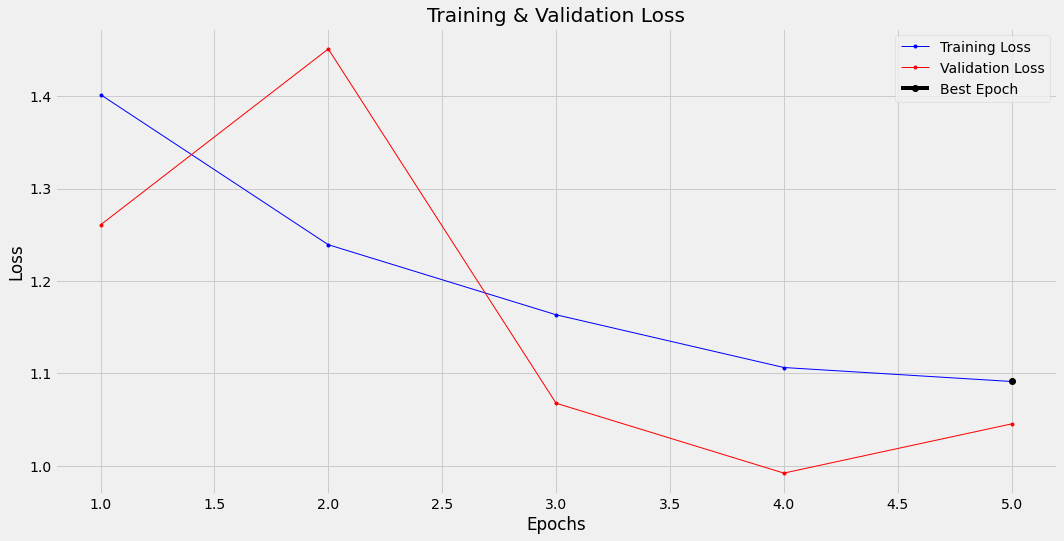

In [70]:
loss_plot(hist=history)

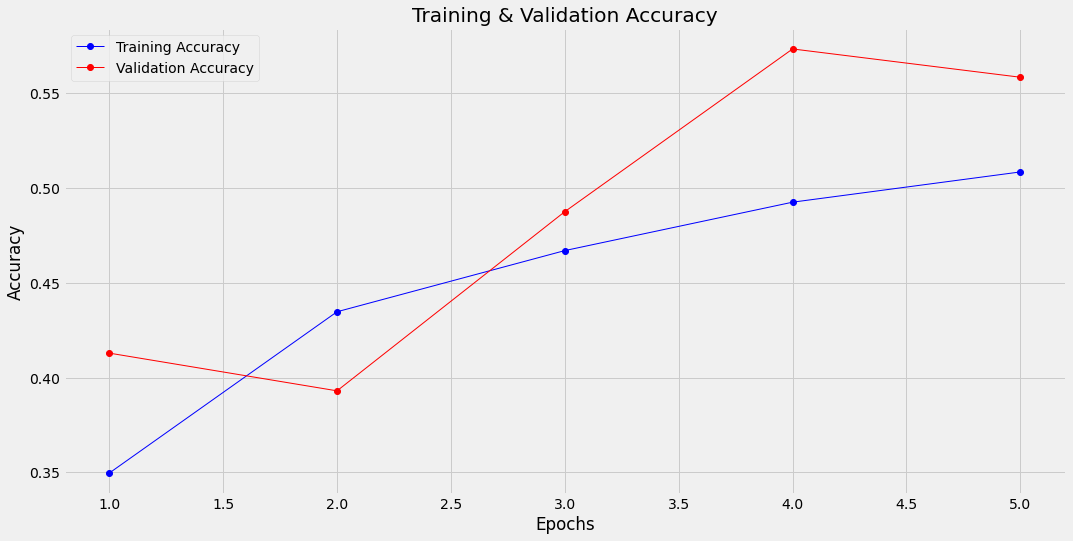

In [32]:
accuracy_plot(hist=history)

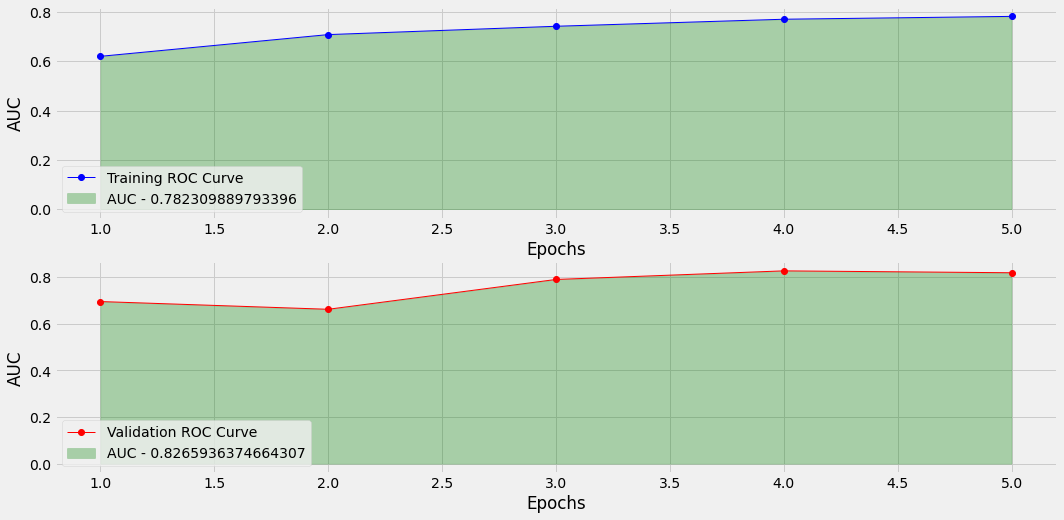

In [56]:
auc_plot(hist=history)